In [4]:
import sys
sys.path.append('../modules')

from datacube import read_data
from operators import *
from preprocessing import *
from eof import *
from gridding import *
from mapper import *
from scipy.stats import linregress

import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.feature
import seaborn as sns
import pandas as pd


%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


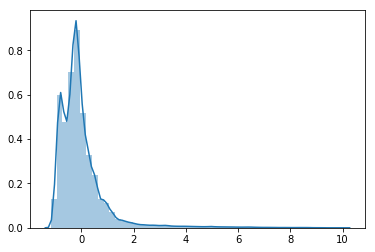

In [5]:
PATH = '/storage/data/projects/nrc/CanRCM4_large_ensemble/design_values/snw/snw_CanRCM4-LE_ens35_1951-2016_max_rl50_load.nc'#tas/hdd_CanRCM4-LE_ens35_1951-2016_ann_ta.nc'#jan1.0p/tas_CanRCM4-LE_ens35_1951-2016_1hr_jan1.0p.nc'
#PATH = '/storage/data/projects/nrc/CanRCM4_large_ensemble/design_values/tas/hdd_CanRCM4-LE_ens35_1951-2016_ann_ta.nc'
mask_path = '/home/nannau/Desktop/climpyrical/data/mask.nc'
dv = 'snw'

interp_dict = get_interpolation(mask_path, PATH, dv)
master_idx = interp_dict['idx']
iens = (interp_dict['iens'][:, master_idx] - interp_dict['iens'][:, master_idx].mean())/np.std(interp_dict['iens'][:, master_idx])
sns.distplot(iens[0, ...])

In [6]:
u, s, vT = np.linalg.svd(iens, full_matrices=False)
del u

Text(0, 0.5, 'Explained Variance Ratio')

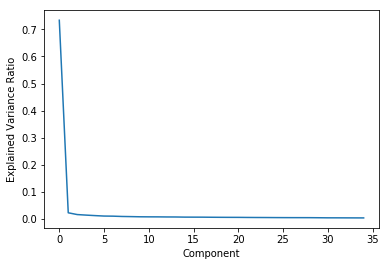

In [7]:
explained_variance_ratio = [s[i]/np.sum(s) for i in range(s.shape[0])]
cumulative_variance = np.cumsum(explained_variance_ratio)
component = range(s.shape[0])

plt.plot(component, explained_variance_ratio)
plt.xlabel('Component')
plt.ylabel('Explained Variance Ratio')

In [8]:
df = pd.read_csv('/storage/data/projects/nrc/station_data/snow_load/swe_rl50_stations_test.csv', index_col=None)


In [9]:
#df = pd.read_csv('/home/nannau/Desktop/query-msc/hdd_1991_2016', index_col=None)
#df = df[df['completeness'] > 0.8]
ndf = match_coords(df, interp_dict, 'snow_load_rl50')
obs_idx = generate_pseudo_obs(iens, 0.0003)
df.head()

,id,station_name,lat,lon,prov,snow_load_rl50,nearest_grid,obs_coords
0,2193,EUREKA A,79.9833,-85.9333,NU,0.936965,387519,"(32.64541886648805, 2.272431308433523)"
1,2027,TUKTOYAKTUK,69.4500,-133.0000,NT,1.815147,469445,"(25.03831355202299, -13.16333698797708)"
2,2029,TUKTOYAKTUK A,69.4333,-133.0260,NT,2.158906,485882,"(25.028017177100875, -13.181003907270492)"
3,2064,BAKER LAKE A,64.2989,-96.0778,NU,3.265956,341555,"(16.80137872475479, 0.41775555963923183)"
4,2072,CHESTERFIELD,63.3333,-90.7167,NU,3.314342,494701,"(15.951712281201985, 2.928277120662789)"


In [10]:
r = 0.15
mean = iens.mean()
obs = iens[0, obs_idx] #- 60#+ np.random.normal(r*np.min(iens[0, obs_idx]), r*np.max(iens[0, obs_idx]), obs_idx.shape[0])
eofs = vT[:4, obs_idx]

print("Check that the observations and the EOFs contain the same number of grids:",
      '\nEOF shape: ', eofs.shape, '\n'
      'Matched Obs shape: ', obs.shape)
mean

Check that the observations and the EOFs contain the same number of grids: 
EOF shape:  (4, 188) 
Matched Obs shape:  (188,)


-1.195632737942021e-15

In [11]:
model = fit_eof(eofs.T, obs.flatten())
predictions = predict_dv(model, eofs.T)
print(model.coef_, model.intercept_)

Regressed model score: 0.9973204808641941 0.9973204808641941
[-791.74859504  -17.3546686    34.48257811  -16.02168373] 0.008362888787449174


slope 0.9973204808641933 r2_val 0.998659341749825


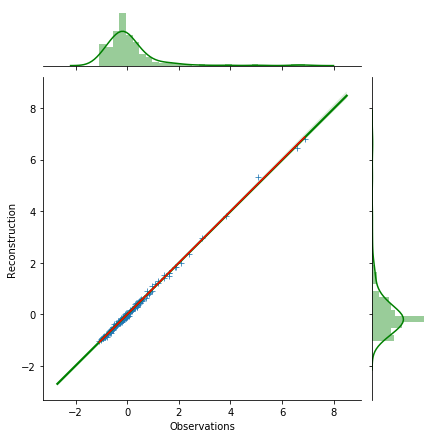

In [12]:
ax = sns.jointplot(obs.T, predictions.T, kind='reg', color='green', marker='+',scatter_kws={"s": 0.01})
sns.scatterplot(obs.T, 
                predictions.T, 
                palette="viridis",
                marker='+'
)
sns.lineplot(
            obs.T, 
            obs.T,
            color='r'
)

plt.xlabel('Observations')
plt.ylabel('Reconstruction')

slope, intercept, r_value, p_value, std_err = linregress(obs.T, predictions.T)

print("slope", slope, "r2_val", r_value)


In [13]:
full_obs = predict_dv(model, vT[:4, ...].T)

"""ax = sns.jointplot(iens[1, ...].T, full_obs.T, kind='reg', color='green', marker='+',scatter_kws={"s": 0.01})

sns.scatterplot(iens[1, ...].T, full_obs.T, 
                palette="viridis",
                marker='+',
                alpha=0.3
)

sns.lineplot(iens[1, ...].T, iens[1, ...], color='r')

plt.xlabel('Observations')
plt.ylabel('Reconstruction')

slope, intercept, r_value, p_value, std_err = linregress(iens[1, ...].T, full_obs.T)

print("slope", slope)"""

'ax = sns.jointplot(iens[1, ...].T, full_obs.T, kind=\'reg\', color=\'green\', marker=\'+\',scatter_kws={"s": 0.01})\n\nsns.scatterplot(iens[1, ...].T, full_obs.T, \n                palette="viridis",\n                marker=\'+\',\n                alpha=0.3\n)\n\nsns.lineplot(iens[1, ...].T, iens[1, ...], color=\'r\')\n\nplt.xlabel(\'Observations\')\nplt.ylabel(\'Reconstruction\')\n\nslope, intercept, r_value, p_value, std_err = linregress(iens[1, ...].T, full_obs.T)\n\nprint("slope", slope)'

In [14]:
newdf = ndf

In [15]:
robs_idx = newdf['matched_idx']
robsmean = newdf['snow_load_rl50'].mean()
robs = (newdf['snow_load_rl50'].values - robsmean)/np.std(interp_dict['iens'][:, master_idx]) 
weights = newdf['lat']
reofs = vT[:7, robs_idx]
reofs[5] = newdf['lat'][robs_idx]
reofs[6] = newdf['lon'][robs_idx]

robsmean

3.4883033317495236

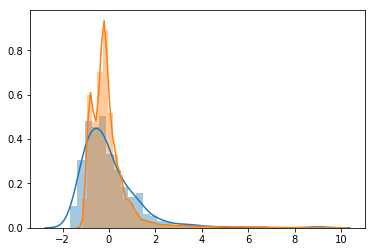

In [16]:
sns.distplot(robs)
sns.distplot(iens[0, ...])

In [48]:
rmodel = fit_eof(reofs.T, robs.flatten())
linrpredictions = predict_dv(rmodel, reofs.T)

import xgboost as xgb

from sklearn.model_selection import train_test_split
xTrain, xTest, yTrain, yTest = train_test_split(reofs.T, robs.flatten(), test_size = 0.3, random_state = 0)
from sklearn.neighbors import KNeighborsRegressor

regr = KNeighborsRegressor(weights='distance', n_neighbors=2)

"""xgb_model = xgb.XGBRegressor(silent=False, 
                      scale_pos_weight=1,
                      learning_rate=0.01,  
                      colsample_bytree = 0.4,
                      subsample = 0.8,
                      objective="reg:squarederror", 
                      n_estimators=10000, 
                      reg_alpha = 0.3,
                      max_depth=16, 
                      gamma=2, random_state=42)

xgb_model.fit(xTrain, yTrain)
rpredictions = xgb_model.predict(xTest)
"""
from sklearn.ensemble import RandomForestRegressor
#regr = RandomForestRegressor(max_depth=16, n_estimators=1000)
regr.fit(xTrain, yTrain)
rpredictions = regr.predict(xTest)
regr.score

Regressed model score: 0.25369731310145827 0.25369731310145827


<bound method RegressorMixin.score of KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=2, p=2,
                    weights='distance')>

In [49]:
xTest.shape, yTest.shape

((158, 7), (158,))

slope 0.6567808448262371 r2_val 0.7666518999310914
slope 0.2536973131014806 r2_val 0.5036837431379518
Std deviation ratio of vectors: 0.9996918408472252
(35, 628708)


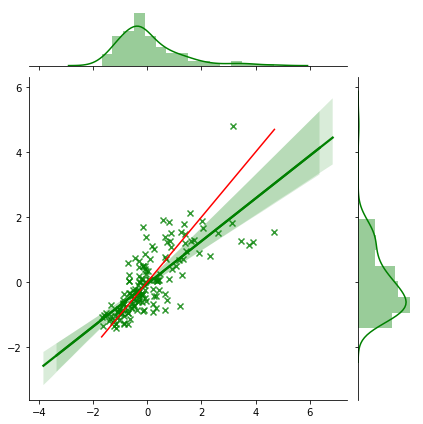

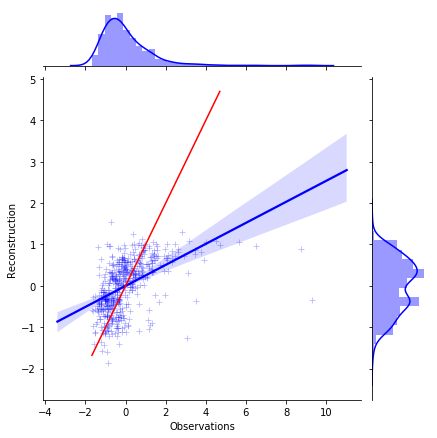

In [55]:
#ax = 
sns.jointplot(yTest, rpredictions, kind='reg', color='green', marker='+',scatter_kws={"s": 0.01})
sns.regplot(yTest, rpredictions, marker='x',
                color="green")
sns.lineplot(yTest.T, 
          yTest.T,
          color='r')
sns.jointplot(robs, linrpredictions, kind='reg', color='blue', marker='+',scatter_kws={"s": 0.01})
sns.scatterplot(robs, linrpredictions, 
                color="blue",
                marker='+',
                alpha=0.3)

sns.lineplot(yTest.T, 
          yTest.T,
          color='r')

plt.xlabel('Observations')
plt.ylabel('Reconstruction')

slope, intercept, r_value, p_value, std_err = linregress(yTest, rpredictions)

print("slope", slope, "r2_val", r_value)

slope, intercept, r_value, p_value, std_err = linregress(robs, linrpredictions)

print("slope", slope, "r2_val", r_value)

print("Std deviation ratio of vectors:", np.mean(np.std(iens, axis=1)))
print(iens.shape)

slope 0.5497157913628796 r2_val 0.6572665621790076
slope 0.6170059592071877 r2_val 0.7352668953856157
slope 0.5742367808973439 r2_val 0.578644201336363


Text(27.125, 0.5, 'Reconstruction')

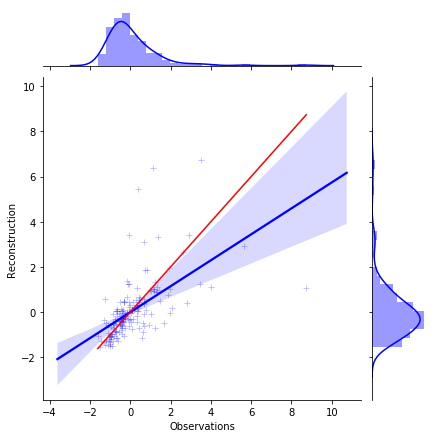

In [53]:
import numpy as np
from sklearn.model_selection import KFold
kf = KFold(n_splits=3, shuffle=True)

X, y = reofs.T, robs.flatten()
slope_arr = []
kf.get_n_splits(X)
for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    regr.fit(X_train, y_train)
    pred = regr. predict(X_test)
    slope, intercept, r_value, p_value, std_err = linregress(y_test, pred)
    slope_arr.append(slope)
    print("slope", slope, "r2_val", r_value)

    
s1, s2, sm = np.array(slope_arr).max(), np.array(slope_arr).min(), np.array(slope_arr).mean()

sns.jointplot(y_test, pred, kind='reg', color='blue', marker='+',scatter_kws={"s": 0.01})

sns.scatterplot(y_test, 
                pred, 
                color="blue",
                marker='+',
                alpha=0.3)

sns.lineplot(
            y_test.T, 
            y_test.T,
            color='r'
)

plt.xlabel('Observations')
plt.ylabel('Reconstruction')

In [ ]:
rmodel.intercept_, rmodel.coef_
vT[:4, ...].shape, reofs.shape

In [ ]:
Y = regr.predict(vT[:4, ...].T)
x = iens[0, ...]

ax = sns.jointplot(x.T, Y.T, kind='reg', color='green', marker='+',scatter_kws={"s": 0.01})

sns.scatterplot(x.T, Y.T, 
                palette="viridis",
                marker='+',
                alpha=0.3
)

sns.lineplot(iens[0, ...].T, iens[0, ...], color='r')

plt.xlabel('Observations')
plt.ylabel('Reconstruction')

slope, intercept, r_value, p_value, std_err = linregress(x, Y)

print("slope", slope)

slope -0.03295155796118271


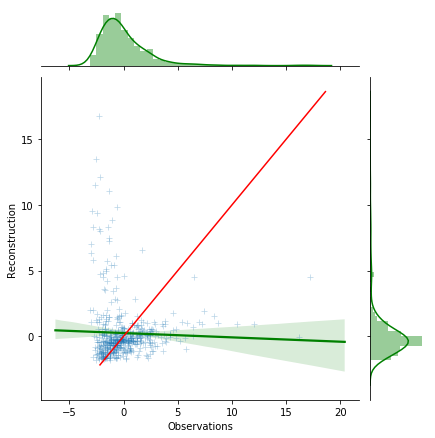

In [100]:
x = robs
Y = iens[0, robs_idx]

ax = sns.jointplot(x.T, Y.T, kind='reg', color='green', marker='+',scatter_kws={"s": 0.01})

sns.scatterplot(x.T, Y.T, 
                palette="viridis",
                marker='+',
                alpha=0.3
)

sns.lineplot(iens[0, ...].T, iens[0, ...], color='r')

plt.xlabel('Observations')
plt.ylabel('Reconstruction')

slope, intercept, r_value, p_value, std_err = linregress(x, Y)

print("slope", slope)

In [174]:
iens_copy = interp_dict['iens'][0, ...].copy()
idxs = (master_idx == True)
iens_copy[idxs] = full_obs

In [175]:
iens_copy

array([0., 0., 0., ..., 0., 0., 0.])

In [176]:
i, j = interp_dict['irlat'].shape[0], interp_dict['irlon'].shape[0]
i, j

(1300, 1550)

In [177]:
final_n_full = np.reshape(iens_copy, (i, j))

In [178]:
final_n_full

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [179]:
iens_copy[np.where(np.isnan(iens_copy) == True)] = 0.0

In [180]:
interp_dict['irlat_ens'], interp_dict['irlon_ens'] 

(array([-28.59999657, -28.59999657, -28.59999657, ...,  28.15999985,
         28.15999985,  28.15999985]),
 array([-33.88000488, -33.83626053, -33.79251617, ...,  33.79251617,
         33.83626053,  33.88000488]))

In [181]:
webdict = to_rotated(interp_dict['irlat_ens'], 
           interp_dict['irlon_ens'])

In [25]:
lon, lat = webdict['rlon_obs'], webdict['rlat_obs'] 
difflon, difflat = np.diff(webdict['rlon_obs']), np.diff(webdict['rlat_obs']) 

In [ ]:
reofs

In [26]:
import json

def get_points(lon, lat, difflon, difflat):
        x1, x2 = lon-difflon, lon+difflon
        y1, y2 = lat-difflat, lat+difflat
        return [x1, x2, y1, y2]

geos = []
for i in range(interp_dict['irlat_ens'].shape[0]-1):

    geometries = {
        'type': 'Feature',
            "geometry": { 
            "type": "Polygon",
            "coordinates": get_points(lon[i], lat[i], difflon[i], difflat[i])
            },

            "id": iens_copy[i]
    }
                    
    geos.append(geometries)  

#geo_str = json.dumps(geometries)

In [27]:
# generate a geojson file for the design value field using plotly!
#geo_str

In [28]:
import geojson
import tempfile

geom_in_geojson = geojson.Feature(geometry=geos)
tmp_file = tempfile.mkstemp(suffix='.geojson')

with open(tmp_file[1], 'w') as outfile:
    geojson.dump(geom_in_geojson, outfile)


KeyboardInterrupt: 

In [46]:
with open(tmp_file[1], 'r') as f:
    dvfieldmap = geojson.load(f)

In [47]:
dvfieldmap['properties']

{}

In [ ]:
geom_in_geojson['features']